#import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings


from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

ratings = pd.read_csv('u.data',delimiter='\t',names=['userId','movieId','rating','time'])
user = pd.read_csv('u.user',delimiter='|',names=['userId','age','gender','job','zip code'])

user.head()

,userId,age,gender,job,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


#read movie data

In [ ]:
items = pd.read_csv('u.item',delimiter='|', encoding='latin-1')
items.columns = ['movieId' , 'movie title' , 'release date' , 'video release date' ,
              'IMDb URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Childrens' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci_Fi' ,
              'Thriller' , 'War' , 'Western']
items = items.drop(columns=['unknown'],axis=1)
items.head()

,movieId,movie title,release date,video release date,IMDb URL,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
user.shape,ratings.shape,items.shape

((943, 5), (100000, 4), (1681, 23))

#merge raings and user info data on userId attribut

In [ ]:
merged1 = pd.merge(ratings,user,on="userId")
merged1.head()

,userId,movieId,rating,time,age,gender,job,zip code
0,196,242,3,881250949,49,M,writer,55105
1,196,393,4,881251863,49,M,writer,55105
2,196,381,4,881251728,49,M,writer,55105
3,196,251,3,881251274,49,M,writer,55105
4,196,655,5,881251793,49,M,writer,55105


#merge merged1 and items on movieId

In [ ]:
merged = pd.merge(merged1,items,on="movieId")
merged.head()

,userId,movieId,rating,time,age,gender,job,zip code,movie title,release date,video release date,IMDb URL,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#encode job and gender (string --> numeric) 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
encoder = OrdinalEncoder()
merged['job'] = encoder.fit_transform(np.array(merged['job']).reshape(-1,1))
merged['gender'] = merged.gender.replace({'M':0,'F':1})
merged.head()

,userId,movieId,rating,time,age,gender,job,zip code,movie title,release date,video release date,IMDb URL,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,196,242,3,881250949,49,0,20.0,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,0,14.0,94086,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,0,6.0,98101,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,0,15.0,94702,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,0,11.0,75240,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#from sklearn.model_selection import train_test_split

#train , test = train_test_split(merged,test_size=0.2,stratify=merged.userId,random_state=123)

#prepare movie title for TextCNN

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merged['movie title'])
item_title_train = tokenizer.texts_to_sequences(merged['movie title'])
vocab_size = len(tokenizer.word_index) + 1  

print(item_title_train[1])
vocab_size

[687, 2]


2481

#pad titles to have the same length

In [ ]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 8
item_title_train = pad_sequences(item_title_train, padding='post', maxlen=maxlen)

In [ ]:
item_title_train[500]

array([317,  80, 155,  18,   0,   0,   0,   0], dtype=int32)

In [ ]:
item_title_train.shape 

(99548, 8)

#Text CNN for movie title

In [ ]:
from keras.models import Sequential
from keras import layers 
embedding_dim = 20
input_title = layers.Input(shape=(maxlen,))
itemtextcnn = layers.Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_title)
itemtextcnn = layers.Conv1D(32, 5, activation='relu')(itemtextcnn)
itemtextcnn = layers.GlobalMaxPooling1D()(itemtextcnn)
itemtextcnn = layers.Dense(16, activation='relu')(itemtextcnn)

#movie input layer (movie id + 18 genre of movies) 

In [ ]:
inp_item = layers.Input(shape=(19,))
itemmodel= layers.Dense(16,activation='relu')(inp_item)

# concat result of textCNN and item network to have item features

In [ ]:
from keras.layers.merge import concatenate as concat

item_feat = concat([itemmodel,itemtextcnn])
item_feat = layers.Dense(16,activation='relu')(item_feat)

#create user network

In [ ]:
user_inp = layers.Input(shape=(4,))
usermodel = layers.Dense(16,activation='relu')(user_inp)

#concat user features (network) with movie features

In [ ]:
feat_user_item = concat([usermodel,item_feat])
feat_user_item = layers.Dense(8,activation='relu')(feat_user_item)

#output layer

In [ ]:
label = layers.Dense(1)(feat_user_item)

# create model that have as input user_info , movie_info , movie_title (textCNN)

In [ ]:
from keras.models import Model
model = Model([user_inp,inp_item,input_title],label)

In [ ]:
model.compile(optimizer='adam', loss='mae', metrics = ['mae']) 

#Get the needed data

In [ ]:
user_train_info = np.array(merged[['userId','age','gender','job']].values)

item_train_info = np.array(merged[['movieId','Action' , 'Adventure' , 'Animation' ,
              'Childrens' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci_Fi' ,
              'Thriller' , 'War' , 'Western']])


In [ ]:
user_train_info

array([[196.,  49.,   0.,  20.],
       [305.,  23.,   0.,  14.],
       [  6.,  42.,   0.,   6.],
       ...,
       [863.,  17.,   0.,  18.],
       [896.,  28.,   0.,  20.],
       [916.,  27.,   0.,   4.]])

In [ ]:
user_train_info.shape,item_train_info.shape,item_title_train.shape,np.array(merged.rating).shape

((99548, 4), (99548, 19), (99548, 8), (99548,))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 8, 20)        49620       ['input_3[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4, 32)        3232        ['embedding_1[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 19)]         0           []                               
                                                                                              

#Model archi

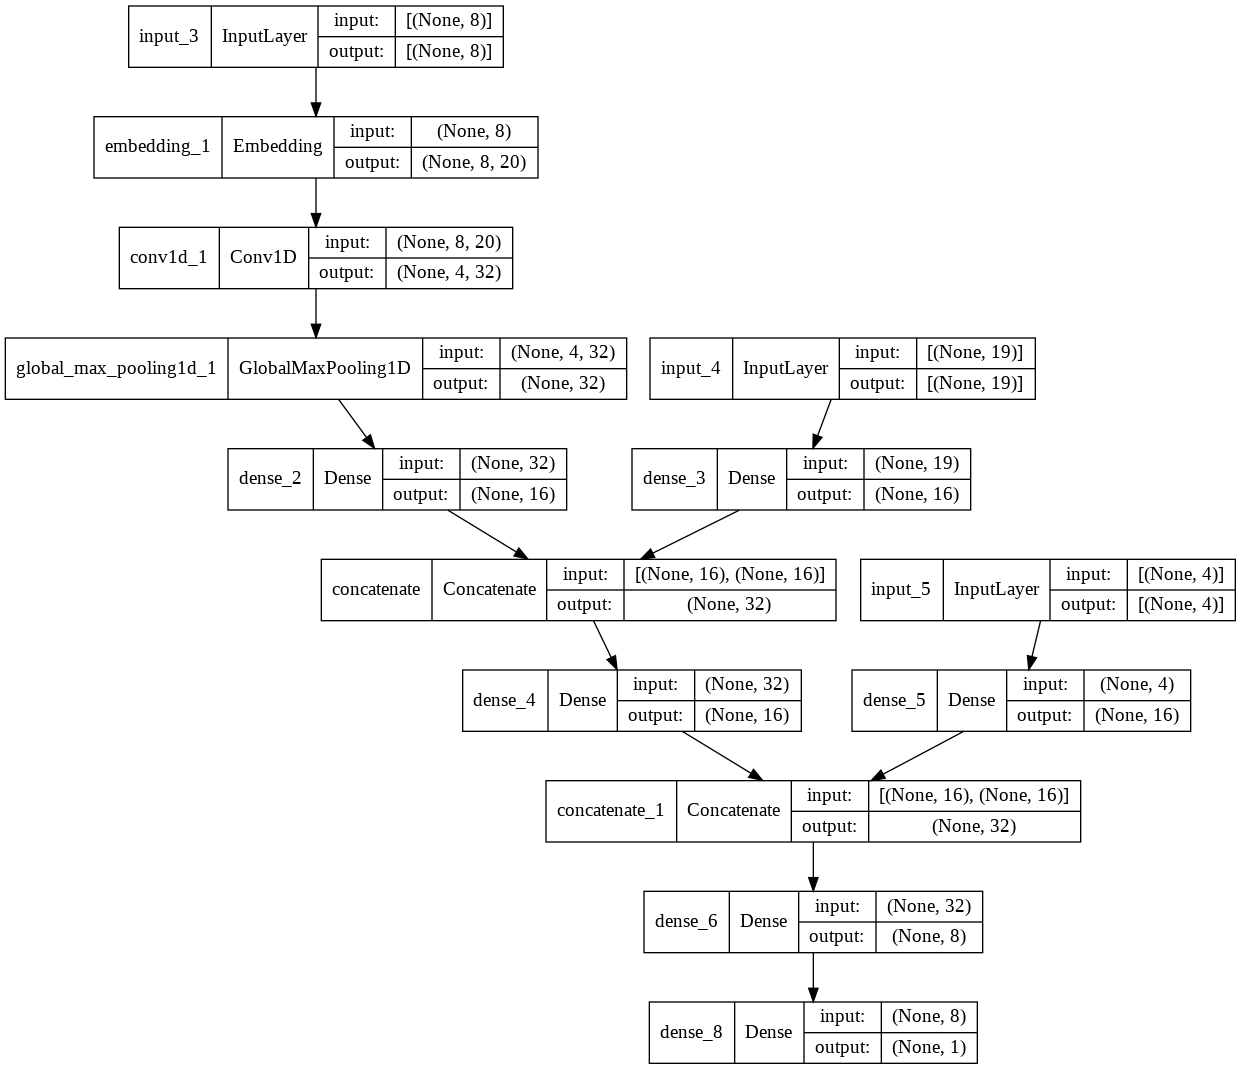

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True)

In [ ]:
#init keras backend session
import keras
keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())

#Train model

In [ ]:
history = model.fit(x=[user_train_info,item_train_info,item_title_train],y=np.array(merged.rating),batch_size=32,epochs=4)

Train on 99548 samples
Epoch 1/4
99548/99548 [==============================] - 15s 155us/sample - loss: 1.1289 - mae: 1.1289
Epoch 2/4
99548/99548 [==============================] - 8s 79us/sample - loss: 0.9324 - mae: 0.9324
Epoch 3/4
99548/99548 [==============================] - 8s 76us/sample - loss: 0.9128 - mae: 0.9128
Epoch 4/4
99548/99548 [==============================] - 7s 75us/sample - loss: 0.8884 - mae: 0.8884


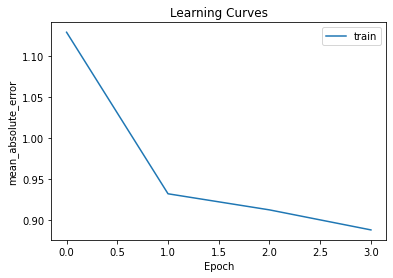

In [ ]:
from matplotlib import pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('mean_absolute_error')
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

#predict

In [ ]:
model.predict([user_train_info,item_train_info,item_title_train])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[3.7434208],
       [3.6942437],
       [4.047832 ],
       ...,
       [1.5752156],
       [1.4111493],
       [1.0590794]], dtype=float32)

#get the leyers responsable for user and movie features

In [ ]:
model_feature = Model(inputs=model.inputs, outputs=[model.layers[-4].output,model.layers[-5].output])

In [ ]:
#last two layers present movie features and user features
model_feature.layers

#get user/mocie features

In [ ]:
user_extracted_feat = model_feature.predict([user_train_info,item_train_info,item_title_train])[1]
item_extracted_feat = model_feature.predict([user_train_info,item_train_info,item_title_train])[0]

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
user_extracted_feat.shape

(99548, 16)

#create new data for CF

In [ ]:
new_data =  pd.DataFrame()
new_data['userId'] = merged.userId
new_data['movie title'] = merged['movie title']
new_data['rating'] = merged.rating

#add user and movie features to our data

In [ ]:
user_feat_names = []
for j in range(1,17):
  new_data['u_f'+str(j)] = user_extracted_feat[:,j-1]

movie_feat_names = []
for j in range(1,17):
  new_data['m_f'+str(j)] = item_extracted_feat[:,j-1]


#save data

In [ ]:
new_data.head()

,userId,movie title,rating,u_f1,u_f2,u_f3,u_f4,u_f5,u_f6,u_f7,u_f8,u_f9,u_f10,u_f11,u_f12,u_f13,u_f14,u_f15,u_f16,m_f1,m_f2,m_f3,m_f4,m_f5,m_f6,m_f7,m_f8,m_f9,m_f10,m_f11,m_f12,m_f13,m_f14,m_f15,m_f16
0,196,Kolya (1996),3,0.0,48.414230,0.000000,0.0,0.0,12.926068,0.0,0.0,54.642574,0.0,109.403160,0.000000,0.0,0.0,63.169098,139.527176,2.181133,11.336082,2.741912,1.384722,9.17754,16.721949,13.383717,4.565056,31.802101,0.0,0.0,16.66531,2.490246,12.298635,20.547251,8.346469
1,305,Kolya (1996),5,0.0,90.752449,0.000000,0.0,0.0,15.775611,0.0,0.0,61.540218,0.0,141.162018,0.000000,0.0,0.0,128.983688,183.001205,2.181133,11.336082,2.741912,1.384722,9.17754,16.721949,13.383717,4.565056,31.802101,0.0,0.0,16.66531,2.490246,12.298635,20.547251,8.346469
2,6,Kolya (1996),4,0.0,0.000000,2.324471,0.0,0.0,4.653491,0.0,0.0,21.713867,0.0,23.706633,12.712609,0.0,0.0,0.000000,27.834925,2.181133,11.336082,2.741912,1.384722,9.17754,16.721949,13.383717,4.565056,31.802101,0.0,0.0,16.66531,2.490246,12.298635,20.547251,8.346469
3,234,Kolya (1996),4,0.0,55.813499,0.000000,0.0,0.0,16.728510,0.0,0.0,68.564949,0.0,129.273529,0.000000,0.0,0.0,78.828979,164.613388,2.181133,11.336082,2.741912,1.384722,9.17754,16.721949,13.383717,4.565056,31.802101,0.0,0.0,16.66531,2.490246,12.298635,20.547251,8.346469
4,63,Kolya (1996),3,0.0,11.092271,0.000000,0.0,0.0,5.439085,0.0,0.0,24.385597,0.0,43.417500,0.000000,0.0,0.0,11.668484,54.515667,2.181133,11.336082,2.741912,1.384722,9.17754,16.721949,13.383717,4.565056,31.802101,0.0,0.0,16.66531,2.490246,12.298635,20.547251,8.346469


In [ ]:
new_data.to_csv('data_with_features.csv',index=False)